# Анализ пролонгации договоров 2023

## Аналитик: Темников Игорь Олегович

## Введение
В данном проекте анализируются коэффициенты пролонгации договоров аккаунт-менеджеров за 2023 год

## Описание данных

- **prolongations.csv**:
  - `id` — id проекта
  - `month` — последний месяц реализации проекта
  - `AM` — ФИО ответственного аккаунт-менеджера (данные первичны по отношению к financial_data, то есть отражают менеджера на момент пролонгации)
- **financial_data.csv**:
  - `id` — id проекта
  - `Причина дубля` — причина, почему строки с одним и тем же id встречаются несколько раз (`первая часть оплаты`, `вторая часть оплаты`, `изменение юридического лица`, `дополнительные работы`, `основные работы`, `карты, банки`)
  - Колонки с названием месяца и года (`Ноябрь 2022`, `Декабрь 2022`, ..., `Февраль 2024`) — сумма отгрузки проекта в данный месяц
  - `Account` — ФИО ответственного аккаунт-менеджера по финансовым данным



## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
prolong = pd.read_csv('data/prolongations.csv')
fin = pd.read_csv('data/financial_data.csv')

In [3]:
prolong.head()

,id,month,AM
0,42,ноябрь 2022,Васильев Артем Александрович
1,453,ноябрь 2022,Васильев Артем Александрович
2,548,ноябрь 2022,Михайлов Андрей Сергеевич
3,87,ноябрь 2022,Соколова Анастасия Викторовна
4,429,ноябрь 2022,Соколова Анастасия Викторовна


In [4]:
fin.head()

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
0,42,NaN,"36 220,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
1,657,первая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
2,657,вторая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
3,594,NaN,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
4,665,NaN,"10 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


# Часто используемые переменные

In [5]:
#Исследуемые месяцы
month_order = [
    'ноябрь 2022', 'декабрь 2022', 'январь 2023', 'февраль 2023', 'март 2023', 'апрель 2023', 'май 2023', 'июнь 2023', 'июль 2023', 'август 2023',
    'сентябрь 2023', 'октябрь 2023', 'ноябрь 2023', 'декабрь 2023',
] 

In [6]:
#Исследуемые месяцы для колонок
month_cols = [col for col in fin.columns if ('2022' in col or '2023' in col or '2024' in col)]

# Предварительный анализ данных
## prolongations.csv

## Структура таблицы

In [7]:
prolong.shape

(477, 3)

In [8]:
prolong.columns

Index(['id', 'month', 'AM'], dtype='object')

In [9]:
prolong.dtypes

id        int64
month    object
AM       object
dtype: object

In [10]:
prolong.isnull().sum()

id       0
month    0
AM       0
dtype: int64

In [11]:
prolong['id'].unique()

array([  42,  453,  548,   87,  429,  600,  657,  594,  665,  586,  637,
        419,  578,  579,  671,  633,  645,  369,  547,  592,  666,  620,
        301,  704,   15,   16,  379,   31,  572,  573,  574,  575,  576,
        448,  492,  597,  708,  719,   39,  328,  716,  613,  615,  617,
        643,   45,  318,   46,   49,  603,  441,  461,  717,  112,  630,
        154,  418,  456,  457,  454,  455,  693,  654,  475,  193,  390,
        477,  478,  535,  709,  581,  623,  196,  199,  705,  629,  720,
        228,  242,  471,  596,  714,  266,  498,  703,  524,  274,  281,
        583,  697,  626,  684,  493,  674,  728,  624,  107,  721,  509,
        649,  687,  519,  230,  732,  529,  348,  381,  556,  640,  101,
        690,  653,  744,  174,  667,  180,  190,  691,  273,  785,  530,
        549,  686,  726,   56,  783,  692,  647,  683,  506,  540,  646,
        768,  713,  244,  562,  682,  580,  789,  797,  798,  799,  800,
         48,  495,  787,  675,  663,  743,  781,  7

In [12]:
prolong['id'].nunique()

313

In [13]:
prolong['month'].unique()

array(['ноябрь 2022', 'декабрь 2022', 'январь 2023', 'февраль 2023',
       'март 2023', 'апрель 2023', 'май 2023', 'июнь 2023', 'июль 2023',
       'август 2023', 'сентябрь 2023', 'октябрь 2023', 'ноябрь 2023',
       'декабрь 2023'], dtype=object)

In [14]:
prolong['month'].nunique()

14

In [15]:
prolong['AM'].unique()

array(['Васильев Артем Александрович', 'Михайлов Андрей Сергеевич',
       'Соколова Анастасия Викторовна', 'Иванова Мария Сергеевна',
       'Попова Екатерина Николаевна', 'Смирнова Ольга Владимировна',
       'Кузнецов Михаил Иванович', 'без А/М', 'Петрова Анна Дмитриевна',
       'Федорова Марина Васильевна'], dtype=object)

In [16]:
prolong['AM'].nunique()

10

## **Вывод**  
Таблица `prolongations.csv`
- содержит 477 записей о проектах (313 проектов уникальны)
- пропуски отсутствуют
- все столбцы имеют ожидаемые типы данных
- в столбце `month` — 14 уникальных месяцев
  - есть ненужный для расчета месяц `ноябрь 2022`
- в столбце `AM` — 10 уникальных аккаунт-менеджеров
  - важно отметить `без А/М` будет использоваться только для рассчета общего коэффициента по отделу

# Предварителотная обработка данных 
## prolongations.csv

Проведём исследовательский анализ, чтобы понять распределения по месяцам и менеджерам, а также выявить возможные аномалии и дубли.

In [17]:
# Поиск и удаление полных дублей
prolong.duplicated().sum()

np.int64(3)

In [18]:
prolong = prolong.drop_duplicates()

In [19]:
# Найдём строки, где по одному проекту и месяцу указано несколько менеджеров
dups = prolong.duplicated(subset=['id', 'month'], keep=False)
prolong[dups]

,id,month,AM
324,361,сентябрь 2023,Смирнова Ольга Владимировна
325,361,сентябрь 2023,Попова Екатерина Николаевна


In [20]:
display(prolong[prolong['id'] == 361])

,id,month,AM
194,361,апрель 2023,Попова Екатерина Николаевна
324,361,сентябрь 2023,Смирнова Ольга Владимировна
325,361,сентябрь 2023,Попова Екатерина Николаевна


In [21]:
display(fin[fin['id'] == 361])

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
247,361,первая часть оплаты,"148 390,00","148 390,00","139 440,00","119 390,00","117 890,00","117 890,00","117 890,00","117 890,00","117 890,00","117 890,00","117 890,00","134 690,00","134 690,00","134 690,00",стоп,NaN,Попова Екатерина Николаевна
248,361,вторая часть оплаты,"6 525,00","18 765,00","16 110,00","9 270,00","3 525,00","18 600,00","35 200,00","14 075,00","8 940,00","15 460,00","16 095,00","13 350,00","8 800,00","27 585,00",стоп,NaN,Попова Екатерина Николаевна


В таблице обнаружены случаи, когда по одному проекту и месяцу указано несколько менеджеров.  
Для дальнейшего анализа такие дубли будут обработаны отдельно  
- Если по проекту и месяцу указан только один менеджер — он остаётся.
- Если несколько — оставляем только того менеджера, который указан в `financial_data.csv` как ответственный за этот проект и месяц.

Это позволяет избежать двойного учёта суммы отгрузки по одному проекту в одном месяце и опираться на финансовую отчётность компании.

In [22]:
prolong['month'].value_counts()

month
декабрь 2023     69
декабрь 2022     67
сентябрь 2023    42
ноябрь 2023      40
июнь 2023        31
март 2023        31
февраль 2023     28
апрель 2023      27
август 2023      26
ноябрь 2022      24
октябрь 2023     24
июль 2023        23
май 2023         22
январь 2023      20
Name: count, dtype: int64

In [23]:
prolong['AM'].value_counts()

AM
Васильев Артем Александрович     136
Соколова Анастасия Викторовна     86
Попова Екатерина Николаевна       76
Смирнова Ольга Владимировна       69
Иванова Мария Сергеевна           48
Михайлов Андрей Сергеевич         31
Кузнецов Михаил Иванович          23
без А/М                            2
Федорова Марина Васильевна         2
Петрова Анна Дмитриевна            1
Name: count, dtype: int64

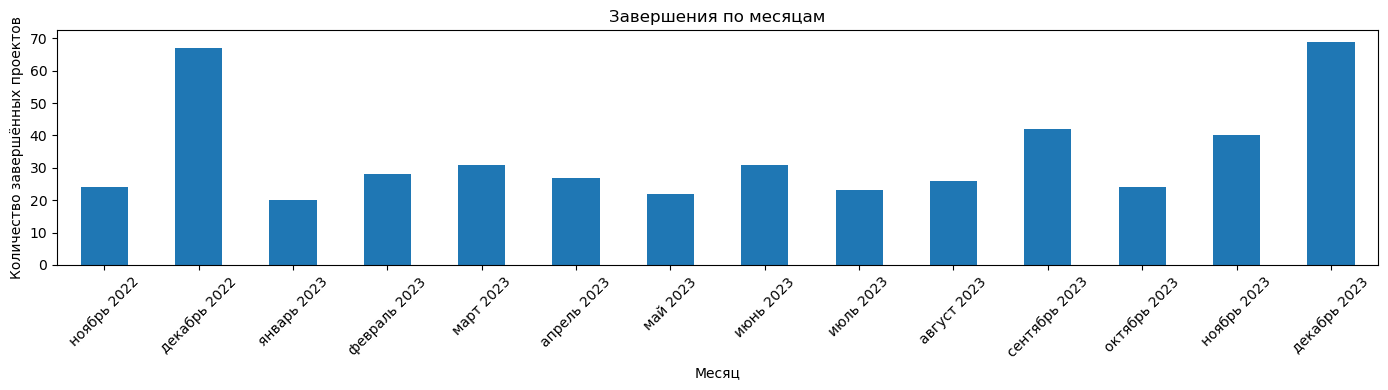

In [24]:
# Распределение по месяцам
vc = prolong['month'].value_counts()
vc = vc.reindex(month_order)
vc.plot(kind='bar', figsize=(14, 4), title='Завершения по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество завершённых проектов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
prolong[prolong['month'] == 'декабрь 2022']['AM'].value_counts()

AM
Васильев Артем Александрович     22
Иванова Мария Сергеевна          16
Михайлов Андрей Сергеевич        10
Соколова Анастасия Викторовна     9
Попова Екатерина Николаевна       6
Смирнова Ольга Владимировна       3
Кузнецов Михаил Иванович          1
Name: count, dtype: int64

In [26]:
prolong[prolong['month'] == 'декабрь 2023']['AM'].value_counts()

AM
Смирнова Ольга Владимировна      18
Васильев Артем Александрович     17
Попова Екатерина Николаевна      13
Соколова Анастасия Викторовна     9
Кузнецов Михаил Иванович          8
Федорова Марина Васильевна        2
Михайлов Андрей Сергеевич         1
без А/М                           1
Name: count, dtype: int64

In [27]:
pivot = pd.pivot_table(
    prolong,
    index='AM',
    columns='month',
    values='id',
    aggfunc='count',
    fill_value=0
)

# Переупорядочим столбцы по month_order
pivot = pivot.reindex(columns=month_order)
display(pivot)

month,ноябрь 2022,декабрь 2022,январь 2023,февраль 2023,март 2023,апрель 2023,май 2023,июнь 2023,июль 2023,август 2023,сентябрь 2023,октябрь 2023,ноябрь 2023,декабрь 2023
AM,,,,,,,,,,,,,,
Васильев Артем Александрович,12,22,5,9,11,11,5,10,5,8,6,8,7,17
Иванова Мария Сергеевна,1,16,0,4,4,1,7,6,5,3,1,0,0,0
Кузнецов Михаил Иванович,0,1,2,1,1,0,0,0,0,0,1,3,6,8
Михайлов Андрей Сергеевич,4,10,2,1,2,3,1,1,0,1,4,0,1,1
Петрова Анна Дмитриевна,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Попова Екатерина Николаевна,2,6,4,7,7,8,3,4,4,4,10,0,4,13
Смирнова Ольга Владимировна,0,3,1,0,2,0,3,2,4,4,10,10,12,18
Соколова Анастасия Викторовна,5,9,6,6,4,4,3,8,4,6,10,3,9,9
Федорова Марина Васильевна,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [28]:
# Считаем количество проектов на каждого менеджера
prolong['AM'].value_counts()


AM
Васильев Артем Александрович     136
Соколова Анастасия Викторовна     86
Попова Екатерина Николаевна       76
Смирнова Ольга Владимировна       69
Иванова Мария Сергеевна           48
Михайлов Андрей Сергеевич         31
Кузнецов Михаил Иванович          23
без А/М                            2
Федорова Марина Васильевна         2
Петрова Анна Дмитриевна            1
Name: count, dtype: int64

In [29]:
# Список "редких" менеджеров
rare_ams = ['Петрова Анна Дмитриевна', 'Федорова Марина Васильевна']

# Фильтруем проекты по этим менеджерам
rare_projects = prolong[prolong['AM'].isin(rare_ams)]
rare_projects

,id,month,AM
401,1012,ноябрь 2023,Петрова Анна Дмитриевна
414,958,декабрь 2023,Федорова Марина Васильевна
470,808,декабрь 2023,Федорова Марина Васильевна


In [30]:
# Получаем список id этих проектов
rare_ids = rare_projects['id'].unique()

# Для каждого id из rare_projects смотрим строки в fin
for pid in rare_ids:
    display(fin[fin['id'] == pid])

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
334,1012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"98 492,00","109 442,52",NaN,NaN,Петрова Анна Дмитриевна


,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
353,958,первая часть оплаты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"91 450,00","83 850,00","84 850,00","50 250,00",NaN,NaN,Федорова Марина Васильевна


,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
441,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"84 000,00","78 000,00","78 000,00","73 050,00","101 020,00","100 285,00","73 050,00",NaN,NaN,NaN,Федорова Марина Васильевна


**Принятая логика**
- Строки с `AM = "без А/М"` не учитываются при расчёте коэффициентов для отдельных менеджеров
- Менеджеры с 1-2 проектами (Петрова Анна Дмитриевна, Федорова Марина Васильевна) будут включены в анализ, но в итоговом отчёте будет отмечено, что по ним мало данных и коэффициенты могут быть неинформативны.

In [31]:
# Для каждого id — список уникальных менеджеров
multi_am = prolong.groupby('id')['AM'].nunique()

multi_am[multi_am > 1]

id
39     2
46     2
48     2
49     2
87     2
107    2
112    2
154    3
196    2
199    2
281    2
361    2
441    2
448    2
495    2
519    2
547    2
569    2
580    2
583    2
586    2
597    2
610    2
629    2
645    2
690    2
712    2
713    2
743    2
744    2
771    2
783    2
785    2
804    2
808    2
848    2
914    2
Name: AM, dtype: int64

In [32]:
for proj_id in multi_am[multi_am > 1].index:
    display(prolong[prolong['id'] == proj_id])

,id,month,AM
38,39,декабрь 2022,Иванова Мария Сергеевна
416,39,декабрь 2023,Попова Екатерина Николаевна


,id,month,AM
47,46,декабрь 2022,Васильев Артем Александрович
420,46,декабрь 2023,Смирнова Ольга Владимировна


,id,month,AM
173,48,апрель 2023,Васильев Артем Александрович
370,48,ноябрь 2023,Смирнова Ольга Владимировна


,id,month,AM
48,49,декабрь 2022,Васильев Артем Александрович
421,49,декабрь 2023,Смирнова Ольга Владимировна


,id,month,AM
3,87,ноябрь 2022,Соколова Анастасия Викторовна
232,87,июнь 2023,Иванова Мария Сергеевна


,id,month,AM
98,107,январь 2023,Васильев Артем Александрович
201,107,май 2023,Васильев Артем Александрович
279,107,август 2023,Васильев Артем Александрович
371,107,ноябрь 2023,Кузнецов Михаил Иванович


,id,month,AM
53,112,декабрь 2022,Иванова Мария Сергеевна
147,112,март 2023,Иванова Мария Сергеевна
235,112,июнь 2023,Иванова Мария Сергеевна
314,112,сентябрь 2023,Михайлов Андрей Сергеевич
429,112,декабрь 2023,Михайлов Андрей Сергеевич


,id,month,AM
55,154,декабрь 2022,Попова Екатерина Николаевна
123,154,февраль 2023,Попова Екатерина Николаевна
177,154,апрель 2023,Попова Екатерина Николаевна
260,154,июль 2023,Иванова Мария Сергеевна
336,154,сентябрь 2023,Соколова Анастасия Викторовна
437,154,декабрь 2023,Соколова Анастасия Викторовна


,id,month,AM
72,196,декабрь 2022,Соколова Анастасия Викторовна
450,196,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
73,199,декабрь 2022,Соколова Анастасия Викторовна
402,199,ноябрь 2023,Кузнецов Михаил Иванович


,id,month,AM
87,281,декабрь 2022,Михайлов Андрей Сергеевич
218,281,май 2023,Соколова Анастасия Викторовна
474,281,декабрь 2023,Соколова Анастасия Викторовна


,id,month,AM
194,361,апрель 2023,Попова Екатерина Николаевна
324,361,сентябрь 2023,Смирнова Ольга Владимировна
325,361,сентябрь 2023,Попова Екатерина Николаевна


,id,month,AM
50,441,декабрь 2022,Михайлов Андрей Сергеевич
229,441,июнь 2023,Васильев Артем Александрович


,id,month,AM
33,448,декабрь 2022,Соколова Анастасия Викторовна
408,448,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
174,495,апрель 2023,Васильев Артем Александрович
254,495,июль 2023,Иванова Мария Сергеевна


,id,month,AM
104,519,январь 2023,Соколова Анастасия Викторовна
366,519,октябрь 2023,Кузнецов Михаил Иванович
403,519,ноябрь 2023,Кузнецов Михаил Иванович


,id,month,AM
18,547,ноябрь 2022,Михайлов Андрей Сергеевич
106,547,январь 2023,Михайлов Андрей Сергеевич
197,547,апрель 2023,Михайлов Андрей Сергеевич
327,547,сентябрь 2023,Михайлов Андрей Сергеевич
463,547,декабрь 2023,Соколова Анастасия Викторовна


,id,month,AM
223,569,июнь 2023,Иванова Мария Сергеевна
409,569,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
165,580,март 2023,Михайлов Андрей Сергеевич
276,580,август 2023,Соколова Анастасия Викторовна


,id,month,AM
88,583,декабрь 2022,Михайлов Андрей Сергеевич
220,583,май 2023,Соколова Анастасия Викторовна


,id,month,AM
9,586,ноябрь 2022,Иванова Мария Сергеевна
259,586,июль 2023,Попова Екатерина Николаевна


,id,month,AM
35,597,декабрь 2022,Михайлов Андрей Сергеевич
410,597,декабрь 2023,Васильев Артем Александрович


,id,month,AM
243,610,июнь 2023,Васильев Артем Александрович
456,610,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
75,629,декабрь 2022,Кузнецов Михаил Иванович
105,629,январь 2023,Кузнецов Михаил Иванович
136,629,февраль 2023,Васильев Артем Александрович
457,629,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
16,645,ноябрь 2022,Соколова Анастасия Викторовна
451,645,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
120,690,февраль 2023,Соколова Анастасия Викторовна
202,690,май 2023,Смирнова Ольга Владимировна
373,690,ноябрь 2023,Смирнова Ольга Владимировна


,id,month,AM
189,712,апрель 2023,Попова Екатерина Николаевна
375,712,ноябрь 2023,Смирнова Ольга Владимировна


,id,month,AM
157,713,март 2023,Попова Екатерина Николаевна
299,713,август 2023,Иванова Мария Сергеевна


,id,month,AM
179,743,апрель 2023,Попова Екатерина Николаевна
261,743,июль 2023,Попова Екатерина Николаевна
350,743,октябрь 2023,Смирнова Ольга Владимировна
443,743,декабрь 2023,Смирнова Ольга Владимировна


,id,month,AM
122,744,февраль 2023,Васильев Артем Александрович
148,744,март 2023,Васильев Артем Александрович
236,744,июнь 2023,Васильев Артем Александрович
316,744,сентябрь 2023,Кузнецов Михаил Иванович
431,744,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
200,771,май 2023,Васильев Артем Александрович
332,771,сентябрь 2023,Смирнова Ольга Владимировна


,id,month,AM
145,783,март 2023,Михайлов Андрей Сергеевич
228,783,июнь 2023,Соколова Анастасия Викторовна
331,783,сентябрь 2023,Соколова Анастасия Викторовна
426,783,декабрь 2023,Соколова Анастасия Викторовна


,id,month,AM
137,785,февраль 2023,Михайлов Андрей Сергеевич
475,785,декабрь 2023,Соколова Анастасия Викторовна


,id,month,AM
198,804,апрель 2023,Попова Екатерина Николаевна
469,804,декабрь 2023,Кузнецов Михаил Иванович


,id,month,AM
265,808,июль 2023,Смирнова Ольга Владимировна
470,808,декабрь 2023,Федорова Марина Васильевна


,id,month,AM
256,848,июль 2023,Соколова Анастасия Викторовна
281,848,август 2023,Смирнова Ольга Владимировна


,id,month,AM
296,914,август 2023,Иванова Мария Сергеевна
337,914,сентябрь 2023,Соколова Анастасия Викторовна
365,914,октябрь 2023,Соколова Анастасия Викторовна
399,914,ноябрь 2023,Соколова Анастасия Викторовна


In [33]:
multi_month = prolong.groupby('id')['month'].nunique()
multi_month[multi_month > 1]

id
15     5
39     2
45     2
46     2
48     2
      ..
940    3
941    2
947    2
956    2
977    2
Name: month, Length: 99, dtype: int64

In [34]:
prolong[prolong['month'].isin(not_2023)]

NameError: name 'not_2023' is not defined

In [ ]:
id_counts = prolong['id'].value_counts()
print(id_counts[id_counts >= 3])

# Предварительный анализ данных
## **financial_data.csv**

In [ ]:
fin.head()

In [ ]:
fin.info()

In [ ]:
pd.Series(fin['Account'].unique(), name='Уникальные значения "Account"')

In [ ]:
fin.isnull().sum().to_frame('Количество пропусков')

In [ ]:
pd.Series(fin['Причина дубля'].unique(), name='Уникальные значения "Причина дубля"')

## Вывод  
Таблица `financial_data.csv`
- содержит 451 запись (строку) о проектах
- пропуски есть только в столбцах "Причина дубля" и по месяцам (это ожидаемо, т.к. не по каждому проекту есть отгрузка в каждом месяце)
- все столбцы имеют ожидаемые типы данных
- в столбцах-месяцах (с ноября 2022 по февраль 2024) много пропусков, что естественно для структуры данных
  - столбец `Ноябрь 2022` не используется для расчёта пролонгации за 2023 год и может быть удалён из анализа
- в столбце `Account` — 10 уникальных аккаунт-менеджеров
  - встречается значение `без А/М` (используется только для общего коэффициента по отделу)
- в столбце `Причина дубля` — 6 уникальных значимых значений ("первая часть оплаты", "вторая часть оплаты", "изменение ЮЛ", "доп работы", "основные работы", "карты, банки") и пропуски
- в данных встречаются специальные значения: `стоп`, `end`, `в ноль` — требуют отдельной обработки при расчётах пролонгации
- дубли по id связаны с разными причинами дубля (разные части оплаты, доп. работы и т.д.), для расчёта сумм по проекту нужно агрегировать все строки с одним id
- таблица готова к дальнейшей обработке: требуется очистка специальных значений, агрегация по id и корректная работа с пропусками и дублями при расчёте коэффициентов пролонгации


# Предварителотная обработка данных 
## **financial_data.csv**

In [ ]:
# Найдём id, которые встречаются более одного раза
duplicate_ids = fin['id'][fin['id'].duplicated(keep=False)]

# Оставим только строки с этими id и где причина дубля NaN
duplicates_with_nan_reason = fin[(fin['id'].isin(duplicate_ids)) & (fin['Причина дубля'].isna())]

# Посмотрим, какие id встречаются более одного раза с NaN в причине дубля
result = duplicates_with_nan_reason['id'].value_counts()
print(result)

duplicates_with_nan_reason

In [ ]:
fin.head(15)

In [35]:
len(prolong)

474

In [36]:
# Найдем полностью одинаковые строки
fin.duplicated().sum()

np.int64(0)

In [37]:
# Получаем список id, где встречается "изменение ЮЛ"
ids_izmenenie_ul = fin[fin['Причина дубля'] == 'изменение ЮЛ']['id'].unique()

# Выводим все строки fin по этим id
fin[fin['id'].isin(ids_izmenenie_ul)]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
19,572,изменение ЮЛ,"56 200,00",стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
20,573,изменение ЮЛ,"69 210,00",стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
21,574,изменение ЮЛ,"46 755,00",стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
22,575,изменение ЮЛ,"25 020,00",стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
23,576,изменение ЮЛ,"36 365,00",стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
41,693,изменение ЮЛ,"81 085,00","82 435,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
82,529,изменение ЮЛ,"75 310,00","71 060,00","71 060,00","76 500,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
101,530,изменение ЮЛ,"44 030,00","48 280,00","44 030,00","44 030,00","48 280,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
105,692,изменение ЮЛ,"47 540,00","48 410,00","52 180,00","45 800,00","46 380,00",end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
214,781,изменение ЮЛ,NaN,NaN,"104 319,00","60 660,00","359 157,00","241 780,00","321 769,75","337 482,75","288 638,50","333 853,75",NaN,NaN,NaN,NaN,NaN,NaN,Михайлов Андрей Сергеевич


- В данных обнаружены проекты с id 572, 573, 574, 575, 576, по которым в таблице `financial_data.csv` в декабре 2022 года указано значение "стоп", а в остальные месяцы отсутствуют какие-либо отгрузки.
- Такие проекты не несут бизнес-смысла для анализа пролонгации, так как были завершены досрочно и не содержат реальных отгрузок после "стоп".
- В соответствии с методологией расчёта пролонгации, эти проекты были полностью исключены из дальнейшего анализа.

- Остальные проекты с причиной дубля "изменение ЮЛ" оставлены в данных и будут рассмотрены на следующих этапах фильтрации и анализа. При необходимости решение о включении или исключении их из итогового расчёта будет принято дополнительно.


In [38]:
# Список id для удаления
ids_to_drop = [572, 573, 574, 575, 576]

# Удаляем из fin
fin = fin[~fin['id'].isin(ids_to_drop)]

# Удаляем из prolong
prolong = prolong[~prolong['id'].isin(ids_to_drop)]

In [39]:
# Получаем список id, где встречается "изменение ЮЛ"
ids_izmenenie_ul = fin[fin['Причина дубля'] == 'изменение ЮЛ']['id'].unique()

# Выводим все строки fin по этим id
fin[fin['id'].isin(ids_izmenenie_ul)]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
41,693,изменение ЮЛ,"81 085,00","82 435,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
82,529,изменение ЮЛ,"75 310,00","71 060,00","71 060,00","76 500,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
101,530,изменение ЮЛ,"44 030,00","48 280,00","44 030,00","44 030,00","48 280,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
105,692,изменение ЮЛ,"47 540,00","48 410,00","52 180,00","45 800,00","46 380,00",end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
214,781,изменение ЮЛ,NaN,NaN,"104 319,00","60 660,00","359 157,00","241 780,00","321 769,75","337 482,75","288 638,50","333 853,75",NaN,NaN,NaN,NaN,NaN,NaN,Михайлов Андрей Сергеевич
264,782,изменение ЮЛ,NaN,NaN,"207 030,00","219 805,00",NaN,NaN,NaN,NaN,NaN,NaN,"316 620,75",NaN,NaN,NaN,NaN,NaN,Михайлов Андрей Сергеевич


In [40]:
# Проверяем, есть ли по этим id другие строки с другими причинами дубля
fin[fin['id'].isin(ids_izmenenie_ul) & (fin['Причина дубля'] != 'изменение ЮЛ')]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account


In [41]:
fin[fin['Причина дубля'] == 'карты, банки']

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
422,228,"карты, банки","28 200,00","28 200,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","33 885,00","43 400,00","43 400,00",Васильев Артем Александрович


В колонках по месяцам могут встречаться такие значения: ‘в ноль’ –  отгрузка проекта в данном месяце равна 0, значит для коэффициента пролонгации нужно взять отгрузку предыдущего месяца (только если все части оплаты равны 0); ‘стоп’ – проект закончился до истечения срока договора, если у проекта есть “стоп” в последний месяц реализации или ранее, то такой проект исключаем из пролонгаций; ‘end’ – аналогично ‘стоп’

In [42]:
len(prolong)

469

In [43]:
# Проверяем только стоп и end в колонках с месяцами
for m in month_order:
    if m in fin.columns:
        values = fin[m].astype(str).str.lower()
        filtered = values[values.isin(['стоп', 'end'])]
        if not filtered.empty:
            print(filtered.value_counts())

In [44]:
print(prolong['month'].unique())
print([col for col in fin.columns if '2022' in col or '2023' in col or '2024' in col])

['ноябрь 2022' 'декабрь 2022' 'январь 2023' 'февраль 2023' 'март 2023'
 'апрель 2023' 'май 2023' 'июнь 2023' 'июль 2023' 'август 2023'
 'сентябрь 2023' 'октябрь 2023' 'ноябрь 2023' 'декабрь 2023']
['Ноябрь 2022', 'Декабрь 2022', 'Январь 2023', 'Февраль 2023', 'Март 2023', 'Апрель 2023', 'Май 2023', 'Июнь 2023', 'Июль 2023', 'Август 2023', 'Сентябрь 2023', 'Октябрь 2023', 'Ноябрь 2023', 'Декабрь 2023', 'Январь 2024', 'Февраль 2024']


In [45]:
# Приводим к одному формату и убираем лишние пробелы
prolong['month'] = prolong['month'].str.title().str.strip()
fin.columns = [col.title().strip() if ('2022' in col or '2023' in col or '2024' in col) else col for col in fin.columns]

In [46]:
fin.columns

Index(['id', 'Причина дубля', 'Ноябрь 2022', 'Декабрь 2022', 'Январь 2023',
       'Февраль 2023', 'Март 2023', 'Апрель 2023', 'Май 2023', 'Июнь 2023',
       'Июль 2023', 'Август 2023', 'Сентябрь 2023', 'Октябрь 2023',
       'Ноябрь 2023', 'Декабрь 2023', 'Январь 2024', 'Февраль 2024',
       'Account'],
      dtype='object')

In [47]:
prolong.head()

,id,month,AM
0,42,Ноябрь 2022,Васильев Артем Александрович
1,453,Ноябрь 2022,Васильев Артем Александрович
2,548,Ноябрь 2022,Михайлов Андрей Сергеевич
3,87,Ноябрь 2022,Соколова Анастасия Викторовна
4,429,Ноябрь 2022,Соколова Анастасия Викторовна


In [48]:
len(prolong)

469

In [49]:
# Множество id, которые нужно исключить
to_exclude = set()

# Для каждого завершённого проекта из prolong
for idx, row in prolong.iterrows():
    pid = row['id']
    last_month = row['month']
    if last_month not in month_order:
        continue  # если вдруг месяц не из списка, пропускаем
    last_idx = month_order.index(last_month)
    months_to_check = month_order[:last_idx+1]
    fin_rows = fin[fin['id'] == pid]
    # Проверяем наличие 'стоп' или 'end' в этих месяцах
    for m in months_to_check:
        if m in fin_rows.columns:
            if ((fin_rows[m] == 'стоп').any() or (fin_rows[m] == 'end').any()):
                to_exclude.add(pid)
                break

# Исключаем такие проекты из prolong и дальнейшего анализа
prolong = prolong[~prolong['id'].isin(to_exclude)]
fin = fin[~fin['id'].isin(to_exclude)]

In [50]:
to_exclude

set()

In [51]:
len(prolong)

469

In [52]:
# Проверяем только 'стоп' и 'end' в колонках с месяцами
for m in month_order:
    if m in fin.columns:
        values = fin[m].astype(str).str.lower()
        filtered = values[values.isin(['стоп', 'end'])]
        if not filtered.empty:
            print(filtered.value_counts())

Остались только те строки, где "стоп"/"end" могут быть в месяцах после завершения проекта. Заменим их на NaN

In [53]:
# Заменяем "стоп" и "end" на NaN
fin[month_cols] = fin[month_cols].replace(
    to_replace=['стоп', 'end', 'Стоп', 'End'],
    value=np.nan
)

In [54]:
# Проверяем только 'стоп' и 'end' в колонках с месяцами
for m in month_order:
    if m in fin.columns:
        values = fin[m].astype(str).str.lower()
        filtered = values[values.isin(['стоп', 'end'])]
        if not filtered.empty:
            print(filtered.value_counts())

In [55]:
excluded_prolong = prolong[prolong['id'].isin(to_exclude)]
excluded_fin = fin[fin['id'].isin(to_exclude)]
display(excluded_prolong)


,id,month,AM


In [56]:
display(excluded_fin)

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account


In [57]:
# Находим id, где хотя бы в одном месяце есть 'стоп' или 'end'
ids_with_stop_end = fin[
    fin[month_cols].apply(lambda row: row.astype(str).str.lower().str.strip().isin(['стоп', 'end']).any(), axis=1)
]['id'].unique()

# Выводим строки из fin по этим id
fin[fin['id'].isin(ids_with_stop_end)]



,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account


In [58]:
# Выводим строки из prolong по этим id
prolong[prolong['id'].isin(ids_with_stop_end)]

,id,month,AM


In [59]:
# Строки, где по всем месяцам только NaN
no_shipments = fin[fin[month_cols].isnull().all(axis=1)]
no_shipments

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
1,657,первая часть оплаты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
2,657,вторая часть оплаты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
3,594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
6,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Михайлов Андрей Сергеевич
16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
32,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Михайлов Андрей Сергеевич
64,626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
65,684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
85,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
92,714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна


In [60]:
no_shipments_ids = no_shipments['id'].unique()
print('Проектов без отгрузок:', len(no_shipments_ids))
print('id проектов:', no_shipments_ids)

Проектов без отгрузок: 15
id проектов: [657 594 419  16 603 626 684 381 714 853 711 907 963 972 997]


In [61]:
len(prolong)

469

- В результате анализа обнаружено 11 проектов, по которым отсутствуют любые отгрузки за весь анализируемый период (все значения по месяцам — NaN).
- Возможные причины: проекты были заведены, но не стартовали; отменены; тестовые или ошибочные записи; либо по ним не было реальных оплат.
- Такие проекты исключаются из дальнейшего анализа пролонгации, так как не влияют на расчёт коэффициентов и не несут бизнес-смысла для задачи удержания клиентов.


In [62]:
# Исключаем проекты без отгрузок из prolong
prolong = prolong[~prolong['id'].isin(no_shipments_ids)]

# Исключаем их и из fin
fin = fin[~fin['id'].isin(no_shipments_ids)]

In [63]:
len(prolong)

453

In [64]:
# Проверяем только Ноябрь 2022 и остальные месяцы
dec_col = 'Ноябрь 2022'
other_months = [col for col in month_cols if col != dec_col]

# Фильтруем в ноябре 2022 что-то есть, а в остальных только NaN
mask = fin[dec_col].notna() & fin[other_months].isna().all(axis=1)
only_december = fin[mask]

only_december[['id', 'Причина дубля', dec_col] + other_months]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024
0,42,NaN,"36 220,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,665,NaN,"10 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,637,NaN,"38 045,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,578,NaN,"82 800,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,579,NaN,в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,592,первая часть оплаты,"92 302,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,592,вторая часть оплаты,"12 340,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,666,NaN,"110 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,620,NaN,в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,704,первая часть оплаты,"35 365,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# Проверяем только Декабрь 2022 и остальные месяцы
dec_col = 'Декабрь 2022'
other_months = [col for col in month_cols if col != dec_col]

# Фильтруем в декабре 2022 что-то есть, а в остальных только NaN
mask = fin[dec_col].notna() & fin[other_months].isna().all(axis=1)
only_december = fin[mask]

only_december[['id', 'Причина дубля', dec_col] + other_months]

,id,Причина дубля,Декабрь 2022,Ноябрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024
35,717,NaN,"34 100,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,705,вторая часть оплаты,"2 110,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,720,первая часть оплаты,"29 127,50",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,720,вторая часть оплаты,"29 127,50",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
len(fin)

430

In [67]:
len(prolong)

453

In [68]:
nov_col = 'Ноябрь 2022'
other_months = [col for col in month_cols if col != nov_col]
mask_nov = fin[nov_col].notna() & fin[other_months].isna().all(axis=1)
ids_nov_only = fin.loc[mask_nov, 'id'].unique()

In [69]:
dec_col = 'Декабрь 2022'
other_months = [col for col in month_cols if col != dec_col]
mask_dec = fin[dec_col].notna() & fin[other_months].isna().all(axis=1)
ids_dec_only = fin.loc[mask_dec, 'id'].unique()

In [70]:
nov_dec_cols = ['Ноябрь 2022', 'Декабрь 2022']
other_months = [col for col in month_cols if col not in nov_dec_cols]
mask_nov_dec = fin[nov_col].notna() & fin[dec_col].notna() & fin[other_months].isna().all(axis=1)
ids_nov_dec_only = fin.loc[mask_nov_dec, 'id'].unique()

In [71]:
ids_to_exclude = set(ids_nov_only) | set(ids_dec_only) | set(ids_nov_dec_only)
fin = fin[~fin['id'].isin(ids_to_exclude)]
prolong = prolong[~prolong['id'].isin(ids_to_exclude)]

In [72]:
len(fin)

374

In [73]:
len(prolong)

406

In [74]:
print(fin['Причина дубля'].unique())

[nan 'первая часть оплаты' 'вторая часть оплаты' 'доп работы'
 'изменение ЮЛ' 'основные работы' 'карты, банки']


## Агрегация строк по id для расчёта пролонгации

В исходных данных по финансовым отгрузкам (financial_data.csv) по одному проекту (id) может быть несколько строк с разными значениями в столбце "Причина дубля" (например, "первая часть оплаты", "вторая часть оплаты", "доп работы", "основные работы", "карты, банки"). Для корректного расчёта коэффициентов пролонгации необходимо агрегировать эти строки так, чтобы по каждому id осталась только одна строка, а суммы по месяцам были просуммированы.

**Реализация**
- Преобразовать все значения в месячных колонках к числовому виду (заменить "в ноль" на отгрузку предыдущего месяца, пропуски оставить как есть, текстовые значения типа "стоп"/"end" — уже обработаны).
- Сгруппировать таблицу по id и просуммировать все месячные колонки.
- Оставить только одну строку на каждый id, где суммы по месяцам отражают общую сумму отгрузок по проекту за каждый месяц.
- Смерджить



In [75]:
# Маска хотя бы в одном месяце есть "в ноль"
mask = fin[month_cols].apply(lambda row: any(x == 'в ноль' for x in row), axis=1)
    
# Выводим такие строки
fin[mask]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
83,453,NaN,в ноль,"39 245,00","44 320,00","177 635,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
114,697,доп работы,NaN,в ноль,в ноль,в ноль,"75 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
123,728,первая часть оплаты,NaN,"780 000,00",в ноль,в ноль,в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
124,667,NaN,NaN,в ноль,"40 620,00","48 715,00","49 610,00","49 850,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
146,301,доп работы,NaN,NaN,NaN,NaN,в ноль,"49 225,00",в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
164,858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,в ноль,в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Смирнова Ольга Владимировна
175,871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"25 000,00",в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
178,553,вторая часть оплаты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,в ноль,"23 015,45","33 307,63",NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
180,346,вторая часть оплаты,NaN,NaN,в ноль,в ноль,в ноль,в ноль,в ноль,в ноль,в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
184,211,основные работы,NaN,NaN,NaN,"171 046,75",NaN,в ноль,"54 111,00","75 000,00",в ноль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


In [76]:
for col in month_cols:
    print(f"{col}: количество 'в ноль' —", (fin[col] == 'в ноль').sum())

Ноябрь 2022: количество 'в ноль' — 1
Декабрь 2022: количество 'в ноль' — 2
Январь 2023: количество 'в ноль' — 4
Февраль 2023: количество 'в ноль' — 5
Март 2023: количество 'в ноль' — 4
Апрель 2023: количество 'в ноль' — 6
Май 2023: количество 'в ноль' — 8
Июнь 2023: количество 'в ноль' — 12
Июль 2023: количество 'в ноль' — 12
Август 2023: количество 'в ноль' — 12
Сентябрь 2023: количество 'в ноль' — 13
Октябрь 2023: количество 'в ноль' — 11
Ноябрь 2023: количество 'в ноль' — 12
Декабрь 2023: количество 'в ноль' — 8
Январь 2024: количество 'в ноль' — 7
Февраль 2024: количество 'в ноль' — 5


Заменим "в ноль" на 0 и приведем к числу

In [77]:
fin[month_cols] = fin[month_cols].replace('в ноль', 0)

for col in month_cols:
    fin[col] = pd.to_numeric(
        fin[col].astype(str).str.replace(' ', '').str.replace(',', '.').str.strip(),
        errors='coerce'
    )

In [78]:
fin.head(15)

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
18,31,NaN,55100.00,55100.00,NaN,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,46200.0,Васильев Артем Александрович
59,242,NaN,96400.00,88850.00,83880.00,90965.0,86975.0,84160.0,75900.0,95105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Соколова Анастасия Викторовна
61,266,NaN,45950.00,45950.00,NaN,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,NaN,Соколова Анастасия Викторовна
63,524,NaN,252293.75,296130.71,243591.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
66,548,NaN,674000.00,674000.00,674000.00,674000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Михайлов Андрей Сергеевич
67,493,первая часть оплаты,36950.00,36950.00,36950.00,NaN,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,55225.0,Смирнова Ольга Владимировна
68,493,вторая часть оплаты,10200.00,11900.00,11050.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Смирнова Ольга Владимировна
69,674,первая часть оплаты,89020.00,95035.00,100355.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
70,674,вторая часть оплаты,17351.00,26034.00,27422.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
73,721,первая часть оплаты,NaN,21000.00,21000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна


In [79]:
# Маска хотя бы в одном месяце есть "0"
mask = fin[month_cols].apply(lambda row: any(x == 0 for x in row), axis=1)
    
# Выводим такие строки
fin[mask]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
83,453,NaN,0.0,39245.0,44320.0,177635.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
114,697,доп работы,NaN,0.0,0.0,0.00,75000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
123,728,первая часть оплаты,NaN,780000.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
124,667,NaN,NaN,0.0,40620.0,48715.00,49610.00,49850.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
146,301,доп работы,NaN,NaN,NaN,NaN,0.00,49225.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
164,858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Смирнова Ольга Владимировна
175,871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Попова Екатерина Николаевна
178,553,вторая часть оплаты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,23015.45,33307.63,NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
180,346,вторая часть оплаты,NaN,NaN,0.0,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иванова Мария Сергеевна
184,211,основные работы,NaN,NaN,NaN,171046.75,NaN,0.00,54111.00,75000.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


In [80]:
desc = fin[month_cols].replace(0, np.nan).describe().T[['min', 'max']]
print(desc)

                   min        max
Ноябрь 2022    4220.00  674000.00
Декабрь 2022   3165.00  780000.00
Январь 2023    1055.00  674000.00
Февраль 2023    915.00  743015.00
Март 2023         0.01  800000.00
Апрель 2023    1022.55  800000.00
Май 2023       1400.00  800000.00
Июнь 2023       915.00  800000.00
Июль 2023       915.00  800000.00
Август 2023     610.00  800000.00
Сентябрь 2023   700.00  800000.00
Октябрь 2023    700.00  800000.00
Ноябрь 2023    1000.00  800000.00
Декабрь 2023    305.00  800000.00
Январь 2024     305.00  776195.25
Февраль 2024    305.00  771132.25


In [81]:
fin[fin['Март 2023'] == 0.01]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
429,471,вторая часть оплаты,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


In [82]:
fin[fin['id'] == 471]

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
428,471,первая часть оплаты,89185.11,74986.18,63305.1,69513.19,75127.44,100518.83,91826.81,103176.17,100914.15,95501.13,96679.36,113011.0,91770.64,99410.96,115821.0,127200.0,Васильев Артем Александрович
429,471,вторая часть оплаты,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


In [83]:
prolong[prolong['id'] == 471]

,id,month,AM
79,471,Декабрь 2022,Васильев Артем Александрович
462,471,Декабрь 2023,Васильев Артем Александрович


- Строка с малой суммой (0.01) оставлена в данных, так как она может быть как техническим остатком, так и особенностями учёта. Для данного отчета такие значения не удаляются, чтобы не потерять потенциально важную информацию.


# Подготовки данных для анализа пролонгации

## Агрегация данных для расчёта коэффициентов пролонгации

Переходим к формированию агрегированной таблицы по каждому проекту (id): для каждого месяца рассчитывается итоговая сумма отгрузки с учётом всех частей оплаты и особенностей бизнес-логики ("в ноль" и NaN). Эта таблица станет основой для дальнейшего расчёта коэффициентов пролонгации по месяцам и менеджерам.


In [84]:
ids = fin['id'].unique()
result = []

for pid in ids:
    row = {'id': pid}
    for i, month in enumerate(month_cols):
        vals = fin[fin['id'] == pid][month]
        # Если все значения NaN — оставляем NaN
        if vals.isna().all():
            row[month] = np.nan
        # Если все значения 0 (и нет ни одного NaN) — берём сумму предыдущего месяца
        elif (vals.fillna(0) == 0).all():
            if i == 0:
                row[month] = np.nan  # для самого первого месяца нет предыдущего, поэтому ставим NaN
            else:
                prev_month = month_cols[i-1]
                prev_vals = fin[fin['id'] == pid][prev_month]
                if prev_vals.isna().all():
                    row[month] = np.nan
                else:
                    row[month] = prev_vals.sum(skipna=True)
        else:
            # Если есть хотя бы одно значение > 0, берём сумму по всем частям оплаты
            row[month] = vals.sum(skipna=True)
    result.append(row)

fin_agg = pd.DataFrame(result)

In [85]:
fin_agg

,id,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024
0,31,55100.00,55100.00,NaN,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,44775.0,46200.0
1,242,96400.00,88850.00,83880.00,90965.0,86975.0,84160.0,75900.0,95105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,266,45950.00,45950.00,NaN,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,NaN
3,524,252293.75,296130.71,243591.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,548,674000.00,674000.00,674000.00,674000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34000.0,34000.0,NaN,NaN
247,281,98000.00,93250.00,82800.00,109000.0,125800.0,91750.0,94700.0,129740.0,117730.0,115860.0,160770.0,142490.0,99125.0,74350.0,105775.0,92065.0
248,785,NaN,NaN,NaN,5306.6,12898.1,5287.0,10180.0,8600.0,3860.0,8600.0,700.0,700.0,700.0,0.0,NaN,NaN
249,913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58200.0,58200.0,58200.0,58200.0,58200.0,58200.0,NaN,NaN


In [86]:
len(fin['id'].unique())

251

In [87]:
len(fin_agg)

251

In [88]:
fin_agg = fin_agg.merge(prolong[['id', 'month', 'AM']], on='id', how='inner')

In [89]:
fin_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             406 non-null    int64  
 1   Ноябрь 2022    158 non-null    float64
 2   Декабрь 2022   177 non-null    float64
 3   Январь 2023    203 non-null    float64
 4   Февраль 2023   221 non-null    float64
 5   Март 2023      229 non-null    float64
 6   Апрель 2023    237 non-null    float64
 7   Май 2023       255 non-null    float64
 8   Июнь 2023      253 non-null    float64
 9   Июль 2023      251 non-null    float64
 10  Август 2023    262 non-null    float64
 11  Сентябрь 2023  236 non-null    float64
 12  Октябрь 2023   224 non-null    float64
 13  Ноябрь 2023    202 non-null    float64
 14  Декабрь 2023   185 non-null    float64
 15  Январь 2024    115 non-null    float64
 16  Февраль 2024   120 non-null    float64
 17  month          406 non-null    object 
 18  AM        

In [90]:
# Привести все названия столбцов к Title Case и убрать лишние пробелы
fin_agg.columns = [col.title().strip() if ('2022' in col or '2023' in col or '2024' in col) else col for col in fin_agg.columns]
month_order = [m.title().strip() for m in month_order]

In [91]:
results = []

for i in range(1, len(month_order)):
    target_month = month_order[i]
    prev_month = month_order[i-1]

    # Только месяцы 2023 года
    if '2023' not in target_month:
        continue

    mask_prev = fin_agg['month'] == prev_month
    S1 = fin_agg.loc[mask_prev, prev_month].sum()
    S2 = fin_agg.loc[mask_prev, target_month].sum()
    k1 = S2 / S1 if S1 > 0 else np.nan

    results.append({
        'Месяц пролонгации': target_month,
        'Коэф. пролонгации 1-й месяц': k1
    })

df_k1_2023 = pd.DataFrame(results)
df_k1_2023

,Месяц пролонгации,Коэф. пролонгации 1-й месяц
0,Январь 2023,0.760169
1,Февраль 2023,0.558198
2,Март 2023,0.650735
3,Апрель 2023,0.473521
4,Май 2023,0.562527
5,Июнь 2023,0.261307
6,Июль 2023,0.545570
7,Август 2023,0.487207
8,Сентябрь 2023,0.328627
9,Октябрь 2023,0.827750


In [92]:
results_k2 = []

for i in range(2, len(month_order)):
    target_month = month_order[i]
    prev_month = month_order[i-1]
    prev_prev_month = month_order[i-2]

    if '2023' not in target_month:
        continue

    # Учитываем NaN, и 0, если есть
    mask_prev_prev = (fin_agg['month'] == prev_prev_month) & (
        (fin_agg[prev_month].isna()) | (fin_agg[prev_month] == 0)
    )
    S1_2 = fin_agg.loc[mask_prev_prev, prev_prev_month].sum()
    S2_2 = fin_agg.loc[mask_prev_prev, target_month].sum()
    k2 = S2_2 / S1_2 if S1_2 > 0 else np.nan

    results_k2.append({
        'Месяц пролонгации': target_month,
        'Коэф. пролонгации 2-й месяц': k2
    })

df_k2_2023 = pd.DataFrame(results_k2)
df_k2_2023

,Месяц пролонгации,Коэф. пролонгации 2-й месяц
0,Январь 2023,0.600049
1,Февраль 2023,0.187705
2,Март 2023,0.081433
3,Апрель 2023,0.092300
4,Май 2023,0.000000
5,Июнь 2023,0.038059
6,Июль 2023,0.106128
7,Август 2023,0.038045
8,Сентябрь 2023,0.000000
9,Октябрь 2023,0.109185


In [93]:
df_k = df_k1_2023.merge(df_k2_2023, on='Месяц пролонгации', how='outer')
df_k

,Месяц пролонгации,Коэф. пролонгации 1-й месяц,Коэф. пролонгации 2-й месяц
0,Август 2023,0.487207,0.038045
1,Апрель 2023,0.473521,0.092300
2,Декабрь 2023,0.544595,0.155498
3,Июль 2023,0.545570,0.106128
4,Июнь 2023,0.261307,0.038059
5,Май 2023,0.562527,0.000000
6,Март 2023,0.650735,0.081433
7,Ноябрь 2023,0.517882,0.018931
8,Октябрь 2023,0.827750,0.109185
9,Сентябрь 2023,0.328627,0.000000


Без А/М

In [94]:
# Оставляем только проекты с назначенным менеджером
fin_agg_with_am = fin_agg[fin_agg['AM'] != 'без А/М']

results_with_am = []

for i in range(1, len(month_order)):
    target_month = month_order[i]
    prev_month = month_order[i-1]

    if '2023' not in target_month:
        continue

    # k1 по отделу (без "без А/М")
    mask_prev = fin_agg_with_am['month'] == prev_month
    S1 = fin_agg_with_am.loc[mask_prev, prev_month].sum()
    S2 = fin_agg_with_am.loc[mask_prev, target_month].sum()
    k1 = S2 / S1 if S1 > 0 else np.nan

    # k2 по отделу (без "без А/М")
    if i > 1:
        prev_prev_month = month_order[i-2]
        mask_prev_prev = (fin_agg_with_am['month'] == prev_prev_month) & (
            (fin_agg_with_am[prev_month].isna()) | (fin_agg_with_am[prev_month] == 0)
        )
        S1_2 = fin_agg_with_am.loc[mask_prev_prev, prev_prev_month].sum()
        S2_2 = fin_agg_with_am.loc[mask_prev_prev, target_month].sum()
        k2 = S2_2 / S1_2 if S1_2 > 0 else np.nan
    else:
        k2 = np.nan

    results_with_am.append({
        'Месяц пролонгации': target_month,
        'Коэф. пролонгации 1-й месяц': k1,
        'Коэф. пролонгации 2-й месяц': k2
    })

df_k_with_am = pd.DataFrame(results_with_am)
df_k_with_am = df_k_with_am[df_k_with_am['Месяц пролонгации'].str.contains('2023')]
df_k_with_am

,Месяц пролонгации,Коэф. пролонгации 1-й месяц,Коэф. пролонгации 2-й месяц
0,Январь 2023,0.760169,0.600049
1,Февраль 2023,0.558198,0.187705
2,Март 2023,0.650735,0.081433
3,Апрель 2023,0.473521,0.092300
4,Май 2023,0.562527,0.000000
5,Июнь 2023,0.261307,0.038059
6,Июль 2023,0.545570,0.106128
7,Август 2023,0.487207,0.038045
8,Сентябрь 2023,0.328627,0.000000
9,Октябрь 2023,0.827750,0.109185


Проекты без А/М не были пролонгированы df_k_with_am == df_k

- Коэффициенты пролонгации для каждого менеджера рассчитываются только по тем проектам, которые были завершены этим менеджером (по данным из prolongations.csv). Проекты других менеджеров не учитываются в индивидуальных коэффициентах.


In [95]:
results_am = []

fin_agg_managers = fin_agg[fin_agg['AM'] != 'без А/М']

for am in fin_agg_managers['AM'].unique():
    for i in range(1, len(month_order)):
        target_month = month_order[i]
        prev_month = month_order[i-1]
        prev_prev_month = month_order[i-2] if i > 1 else None

        if '2023' not in target_month:
            continue

        # k1 для менеджера
        mask_prev = (fin_agg_managers['month'] == prev_month) & (fin_agg_managers['AM'] == am)
        S1 = fin_agg_managers.loc[mask_prev, prev_month].sum()
        S2 = fin_agg_managers.loc[mask_prev, target_month].sum()
        k1 = S2 / S1 if S1 > 0 else np.nan

        # k2 для менеджера
        if prev_prev_month:
            mask_prev_prev = (fin_agg_managers['month'] == prev_prev_month) & (fin_agg_managers['AM'] == am) & (
                (fin_agg_managers[prev_month].isna()) | (fin_agg_managers[prev_month] == 0)
            )
            S1_2 = fin_agg_managers.loc[mask_prev_prev, prev_prev_month].sum()
            S2_2 = fin_agg_managers.loc[mask_prev_prev, target_month].sum()
            k2 = S2_2 / S1_2 if S1_2 > 0 else np.nan
        else:
            k2 = np.nan

        results_am.append({
            'Менеджер': am,
            'Месяц пролонгации': target_month,
            'Коэф. пролонгации 1-й месяц': k1,
            'Коэф. пролонгации 2-й месяц': k2
        })

df_k_am = pd.DataFrame(results_am)
df_k_am = df_k_am[df_k_am['Месяц пролонгации'].str.contains('2023')]
df_k_am

,Менеджер,Месяц пролонгации,Коэф. пролонгации 1-й месяц,Коэф. пролонгации 2-й месяц
0,Васильев Артем Александрович,Январь 2023,0.661835,NaN
1,Васильев Артем Александрович,Февраль 2023,1.056563,0.068102
2,Васильев Артем Александрович,Март 2023,0.627250,0.707823
3,Васильев Артем Александрович,Апрель 2023,0.466389,0.110203
4,Васильев Артем Александрович,Май 2023,0.449223,0.000000
...,...,...,...,...
103,Федорова Марина Васильевна,Август 2023,NaN,NaN
104,Федорова Марина Васильевна,Сентябрь 2023,NaN,NaN
105,Федорова Марина Васильевна,Октябрь 2023,NaN,NaN
106,Федорова Марина Васильевна,Ноябрь 2023,NaN,NaN


# Визуализация данных и сохранение результатов

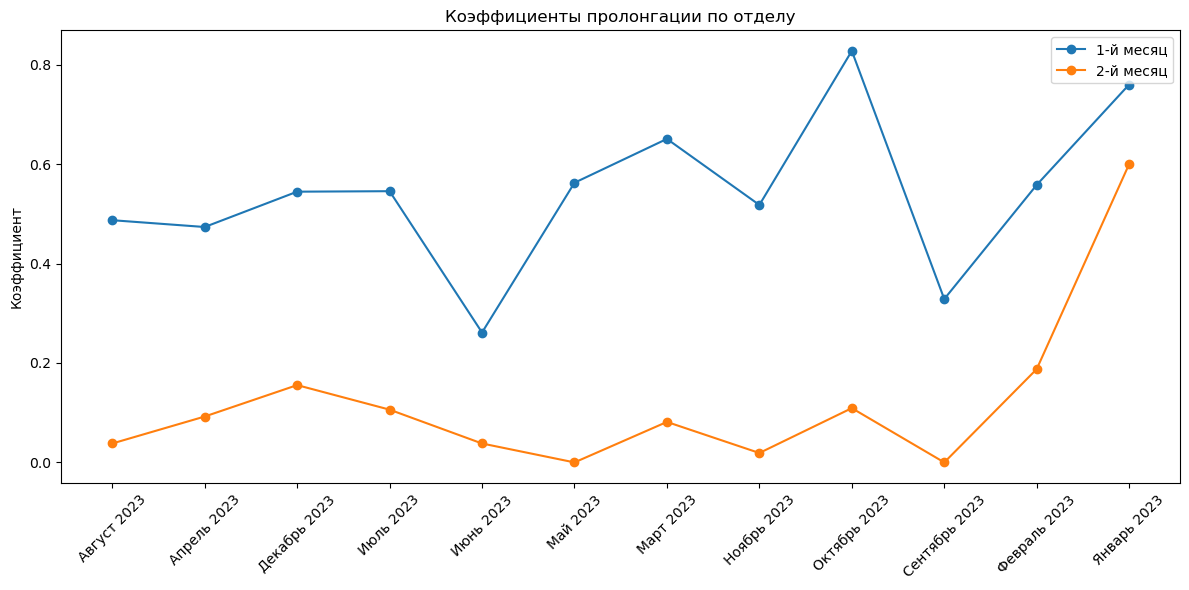

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(df_k['Месяц пролонгации'], df_k['Коэф. пролонгации 1-й месяц'], marker='o', label='1-й месяц')
plt.plot(df_k['Месяц пролонгации'], df_k['Коэф. пролонгации 2-й месяц'], marker='o', label='2-й месяц')
plt.xticks(rotation=45)
plt.title('Коэффициенты пролонгации по отделу')
plt.ylabel('Коэффициент')
plt.legend()
plt.tight_layout()
plt.savefig('results/prolongation_coeffs_dept.png')
plt.show()

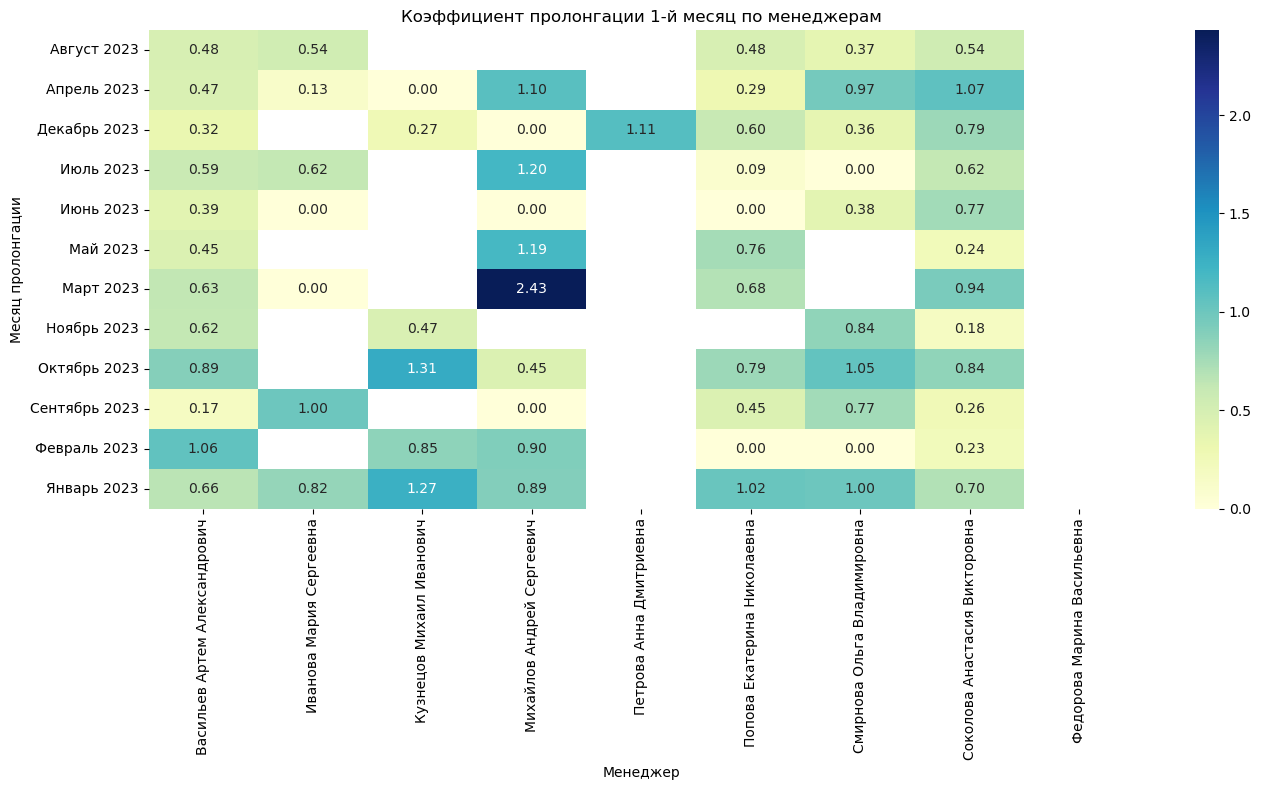

In [97]:
# Поворот таблицы для heatmap
pivot_am = df_k_am.pivot(index='Месяц пролонгации', columns='Менеджер', values='Коэф. пролонгации 1-й месяц')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_am, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Коэффициент пролонгации 1-й месяц по менеджерам')
plt.ylabel('Месяц пролонгации')
plt.xlabel('Менеджер')
plt.tight_layout()
plt.savefig('results/prolongation_coeffs_managers.png')
plt.show()

In [98]:
results = {
    'Отдел': df_k,
    'По менеджерам': df_k_am,
}

In [99]:
with pd.ExcelWriter('results/prolongation_report.xlsx', engine='xlsxwriter') as writer:
    for sheet, df in results.items():
        df.to_excel(writer, sheet_name=sheet[:31], index=False)

## Заключение

В ходе анализа были реализованы все этапы обработки и расчёта коэффициентов пролонгации в соответствии с бизнес-логикой задачи. Код структурирован по этапам. 
 - Загрузка данных
 - Предварительный анализ каждой из таблиц
 - Предварительная обработка каждой из таблиц
 - Подготовка и Агрегация данных для анализа пролонгации
 - Визуализация и сохранение результатов

Все ключевые шаги снабжены пояснениями, что обеспечивает прозрачность и воспроизводимость анализа.

Результаты оформлены в виде Excel-отчёта с подробными таблицами и графиками, а также в виде блокнота Jupyter Notebookс подробным кодом и комментариями.

